<a href="https://colab.research.google.com/github/abdallaho98/AutoSpeech/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install ktrain

     |████████████████████████████████| 25.3MB 169kB/s 
     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 983kB 43.8MB/s 
     |████████████████████████████████| 245kB 46.4MB/s 
     |████████████████████████████████| 778kB 41.5MB/s 
     |████████████████████████████████| 471kB 40.3MB/s 
     |████████████████████████████████| 3.9MB 39.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 450kB 44.0MB/s 
     |████████████████████████████████| 1.1MB 39.4MB/s 
     |████████████████████████████████| 3.0MB 43.0MB/s 
     |████████████████████████████████| 890kB 44.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.19.8-cp36-none-any.whl size=25268462 sha256=8fe1e596389b4c3600bc2f4180037e645bbabab6189db6b885542cb5e636b65b
  Stored in directory: /root/.cache/pip/wheels/53/0d/49/76e18efeba19337a3dd626260325525e61c2e83974d6bbeae4
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [3]:
import ktrain
from ktrain import text

In [4]:
import pandas as pd
filepath = 'legalts.txt'
df = pd.DataFrame(columns=('type', 'content'))
with open(filepath) as fp:
   line = fp.readline()
   cnt = 0
   while line:
       x = line.strip().split("  ")
       df.loc[cnt] = [int(x[1]) , x[0]]
       line = fp.readline()
       cnt += 1
df['type'] = df['type'].apply(lambda x: 'right' if x == 1 else 'permit' if x == 2 else 'obligation' if x == 3 else 'prohibition' if x == 4 else 'other')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'right', 'permit','obligation' ,'prohibition' , 'other']]
df.head()

,text,right,permit,obligation,prohibition,other
0,ليس للشركاء في مال شائع أن يطلبوا قسمته إذا تب...,0,0,0,1,0
1,إذا وقع تحريف في نص السفتجة فالأشخاص الموقعون ...,0,0,0,0,1
2,يجوز الحجز على الأجر أو المرتب بقيمة النفقة ال...,0,1,0,0,0
3,يعين القاضي طبقا لأحكام قانون الأسرة، مقدما من...,0,0,1,0,0
4,يجوز للعموم المعارضة في أي تصحيح قضائي أو إدار...,0,1,0,0,0


In [5]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['right', 'permit','obligation' ,'prohibition' , 'other'],
                                                                   maxlen=575, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)

language: ar
Word Counts: 6788
Nrows: 931
931 train sequences
train sequence lengths:
	mean : 27
	95percentile : 49
	99percentile : 62
Adding 3-gram features
max_features changed to 139279 with addition of ngrams
Average train sequence length with ngrams: 78
train (w/ngrams) sequence lengths:
	mean : 79
	95percentile : 144
	99percentile : 183
x_train shape: (931,575)
y_train shape: (931, 5)
Is Multi-Label? False
104 test sequences
test sequence lengths:
	mean : 21
	95percentile : 36
	99percentile : 41
Average test sequence length with ngrams: 33
test (w/ngrams) sequence lengths:
	mean : 34
	95percentile : 76
	99percentile : 90
x_test shape: (104,575)
y_test shape: (104, 5)


In [17]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=64)

Is Multi-Label? False
compiling word ID features...
maxlen is 575
building document-term matrix... this may take a few moments...
rows: 1-931
computing log-count ratios...
done.


simulating training for different learning rates... this may take a few moments...
Train on 931 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:547: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


931/931 [==============================] - 0s 488us/sample - loss: 1.6065 - accuracy: 0.3835
Epoch 2/5
931/931 [==============================] - 0s 125us/sample - loss: 1.6042 - accuracy: 0.4103
Epoch 3/5
931/931 [==============================] - 0s 120us/sample - loss: 1.5191 - accuracy: 0.7884
Epoch 4/5
931/931 [==============================] - 0s 127us/sample - loss: 0.5192 - accuracy: 0.9710
Epoch 5/5
931/931 [==============================] - 0s 123us/sample - loss: 0.3419 - accuracy: 0.9957


done.
Visually inspect loss plot and select learning rate associated with falling loss


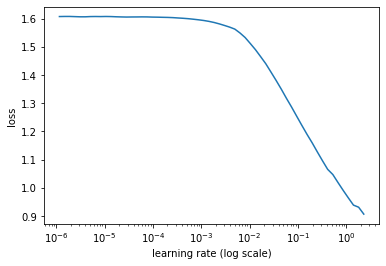

In [18]:
learner.lr_find(show_plot=True)

In [31]:
learner.autofit(5e-2, 1)



begin training using triangular learning rate policy with max lr of 0.05...
Train on 931 samples, validate on 104 samples
931/931 [==============================] - 0s 131us/sample - loss: 0.0696 - accuracy: 0.9946 - val_loss: 0.9790 - val_accuracy: 0.6827


In [29]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:20 | loss:7.75 | true:obligation | pred:other)

اللجنة القطاعية للصفقات فيما يأتي مراقبة صحة إجراءات إبرام الصفقات العمومية، المصالح المتعاقدة التابعة لها في مجال تحضير الصفقات العمومية وإتمام تراتيبها، المساهمة في تحسين ظروف مراقبة صحة إجراءات إبرام الصفقات العمومية


In [23]:
p = ktrain.get_predictor(learner.model, preproc)

In [28]:
p.predict("لا يجوز أن يكون تأويل العبارات الغامضة في عقود الاذعان ضارا بمصلحة الطرف المذعن")

'prohibition'

In [25]:
p.predict("يسقط الحق في إبطال العقد إذا لم يتمسك به صاحبه خلال خمس )5( سنوات.")

'right'

In [26]:
p.predict("يجوز أن يؤمر بالنفاذ المعجل بالنسبة لهذا الإجرا")

'permit'

In [27]:
p.predict("يجوز تخفيض العقوبة المنصوص عليها قانونا بالنسبة للشخص الطبيعي الذي قضي بإدانته وتقررت إفادته بظروف مخففة")

'permit'